In [2]:
import pandas as pd
import numpy as np
import pickle

import itertools
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report

import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns


x_train_text = pd.read_csv('data/t2e/text_train.csv')
x_test_text = pd.read_csv('data/t2e/text_test.csv')

y_train_text = x_train_text['label']
y_test_text = x_test_text['label']

x_train_audio = pd.read_csv('data/s2e/audio_train.csv')
x_test_audio = pd.read_csv('data/s2e/audio_test.csv')


y_train_audio = x_train_audio['label']
y_test_audio = x_test_audio['label']

y_train = y_train_audio  # since y_train_audio == y_train_text
y_test = y_test_audio  # since y_train_audio == y_train_text

print(x_train_text.shape, y_train_text.shape, x_train_audio.shape, y_train_audio.shape)

(54022, 3) (54022,) (54022, 10) (54022,)


In [19]:
print(x_test_text.shape, y_test_text.shape, x_test_audio.shape, y_test_audio.shape)

(13506, 2606) (13506,) (13506, 10) (13506,)


In [3]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

id_to_emotion = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    print(classification_report(y_test, pred, target_names=emo_keys))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

In [4]:
cl_weight = dict(pd.Series(x_train_audio['label']).value_counts(normalize=True))

## Get Text Features

In [5]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features_text = tfidf.fit_transform(x_train_text.append(x_test_text).transcription).toarray()

x_train_text = features_text[:x_train_text.shape[0]]
x_test_text = features_text[-x_test_text.shape[0]:]

print(features_text.shape, x_train_text.shape, x_test_text.shape)

(67528, 2606) (54022, 2606) (13506, 2606)


## Combine Text + Audio Features

In [8]:
combined_x_train = np.concatenate((np.array(x_train_audio[x_train_audio.columns[2:]]), x_train_text), axis=1)
combined_x_test = np.concatenate((np.array(x_test_audio[x_test_audio.columns[2:]]), x_test_text), axis=1)

print(combined_x_train.shape, combined_x_test.shape)

combined_features_dict = {}

combined_features_dict['x_train'] = combined_x_train
combined_features_dict['x_test'] = combined_x_test
combined_features_dict['y_train'] = np.array(y_train)
combined_features_dict['y_test'] = np.array(y_test)

with open('data/combined/combined_features.pkl', 'wb') as f:
    pickle.dump(combined_features_dict, f)

(54022, 2614) (13506, 2614)


Test Set Accuracy =  0.946
Test Set F-score =  0.680
Test Set Precision =  0.727
Test Set Recall =  0.667
              precision    recall  f1-score   support

         ang       0.63      0.41      0.49       241
         hap       0.64      0.40      0.49       360
         sad       0.52      0.81      0.64       633
         fea       1.00      1.00      1.00      8972
         sur       1.00      1.00      1.00      2898
         neu       0.58      0.38      0.46       402

    accuracy                           0.95     13506
   macro avg       0.73      0.67      0.68     13506
weighted avg       0.95      0.95      0.94     13506

Confusion matrix, without normalization
[[  98   27  109    0    1    6]
 [  16  145  151    1    1   46]
 [  27   31  514    0    1   60]
 [   0    0    0 8972    0    0]
 [   0    0    0    0 2898    0]
 [  15   25  207    0    3  152]]


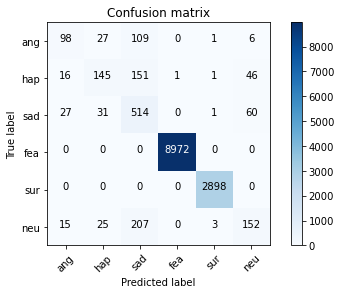

In [10]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/combined_rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

with open('trained_models/combined/RF.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

[20:21:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sub_sample" } are not used.

Test Set Accuracy =  0.915
Test Set F-score =  0.577
Test Set Precision =  0.720
Test Set Recall =  0.526
              precision    recall  f1-score   support

         ang       0.63      0.34      0.45       241
         hap       0.61      0.25      0.35       360
         sad       0.63      0.39      0.48       633
         fea       0.95      1.00      0.97      8972
         sur       0.89      1.00      0.94      2898
         neu       0.61      0.17      0.27       402

    accuracy                           0.92     13506
   macro avg       0.72      0.53      0.58     13506
weighted avg       0.90      0.92      0.90     13506

Confusion matrix, without normalization
[[  83   15   26   63   51    3]
 [  15   89   49  112   76   19]
 [  19   16  247  187  142   22]
 [   0    0 

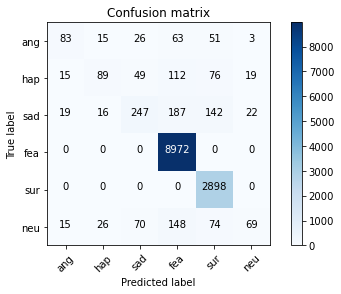

In [16]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=600, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/combined_xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

with open('trained_models/combined/XGB.pkl', 'wb') as f:
    pickle.dump(xgb_classifier, f)

Test Set Accuracy =  0.900
Test Set F-score =  0.679
Test Set Precision =  0.729
Test Set Recall =  0.642
Confusion matrix, without normalization
[[ 110    8   71   23   10   19]
 [   4  230   49   27   16   34]
 [  47   32  373   64   27   90]
 [   0    0    0 8972    0    0]
 [   0    0    0  570 2328    0]
 [  12   43  122   46   32  147]]


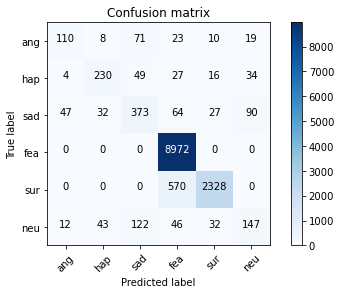

In [12]:
svc_classifier = LinearSVC()

svc_classifier.fit(combined_x_train, y_train)

# Predict
pred = svc_classifier.predict(combined_x_test)

# Results
one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)
(y_test, pred_probs)

with open('pred_probas/combined_svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)
    
with open('trained_models/combined/SVC.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.886
Test Set F-score =  0.624
Test Set Precision =  0.745
Test Set Recall =  0.570
              precision    recall  f1-score   support

         ang       0.70      0.30      0.42       241
         hap       0.82      0.49      0.61       360
         sad       0.54      0.59      0.56       633
         fea       0.91      1.00      0.96      8972
         sur       0.91      0.79      0.84      2898
         neu       0.59      0.25      0.35       402

    accuracy                           0.89     13506
   macro avg       0.74      0.57      0.62     13506
weighted avg       0.88      0.89      0.88     13506

Confusion matrix, without normalization
[[  73    2   86   34   42    4]
 [   0  176   78   39   45   22]
 [  29   14  375   87   85   43]
 [   0    0    0 8972    0    0]
 [   0    0    0  623 2275    0]
 [   3   22  160   60   57  100]]


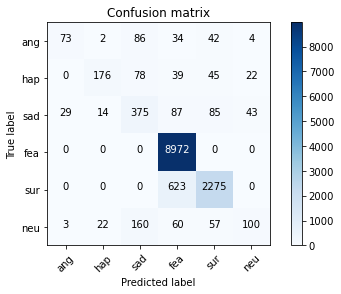

In [13]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/combined_mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
with open('trained_models/combined/MNB.pkl', 'wb') as f:
    pickle.dump(mnb_classifier, f)

Iteration 1, loss = 0.31176927
Iteration 2, loss = 0.18811428
Iteration 3, loss = 0.15207732
Iteration 4, loss = 0.13214166
Iteration 5, loss = 0.11595486
Iteration 6, loss = 0.10661792
Iteration 7, loss = 0.09832013
Iteration 8, loss = 0.09212079
Iteration 9, loss = 0.08930565
Iteration 10, loss = 0.08365273
Iteration 11, loss = 0.08129129
Iteration 12, loss = 0.07827469
Iteration 13, loss = 0.07469717
Iteration 14, loss = 0.07406752
Iteration 15, loss = 0.07260967
Iteration 16, loss = 0.07031327
Iteration 17, loss = 0.06937357
Iteration 18, loss = 0.06825106
Iteration 19, loss = 0.06621499
Iteration 20, loss = 0.06452779
Iteration 21, loss = 0.06473406
Iteration 22, loss = 0.06273890
Iteration 23, loss = 0.06262088
Iteration 24, loss = 0.06231360
Iteration 25, loss = 0.06183066


C:\Users\Alexander\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Test Set Accuracy =  0.950
Test Set F-score =  0.730
Test Set Precision =  0.742
Test Set Recall =  0.720
              precision    recall  f1-score   support

         ang       0.61      0.54      0.57       241
         hap       0.66      0.70      0.68       360
         sad       0.67      0.60      0.63       633
         fea       1.00      1.00      1.00      8972
         sur       0.97      1.00      0.99      2898
         neu       0.55      0.48      0.52       402

    accuracy                           0.95     13506
   macro avg       0.74      0.72      0.73     13506
weighted avg       0.95      0.95      0.95     13506

Confusion matrix, without normalization
[[ 129   22   45    6   14   25]
 [   8  253   45    8   11   35]
 [  55   51  380   16   34   97]
 [   0    0    0 8972    0    0]
 [   0    0    0    0 2898    0]
 [  21   57  101    6   23  194]]


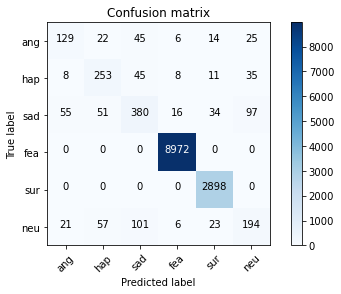

In [15]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=True, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/combined_mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
with open('trained_models/combined/MLP.pkl', 'wb') as f:
    pickle.dump(mlp_classifier, f)

Test Set Accuracy =  0.892
Test Set F-score =  0.649
Test Set Precision =  0.751
Test Set Recall =  0.592
              precision    recall  f1-score   support

         ang       0.72      0.40      0.51       241
         hap       0.80      0.49      0.61       360
         sad       0.59      0.58      0.58       633
         fea       0.91      1.00      0.95      8972
         sur       0.94      0.80      0.87      2898
         neu       0.55      0.29      0.38       402

    accuracy                           0.89     13506
   macro avg       0.75      0.59      0.65     13506
weighted avg       0.88      0.89      0.88     13506

Confusion matrix, without normalization
[[  96    2   72   39   20   12]
 [   1  176   53   62   42   26]
 [  32   16  364  119   46   56]
 [   0    0    0 8972    0    0]
 [   0    0    0  570 2328    0]
 [   5   26  131   83   42  115]]


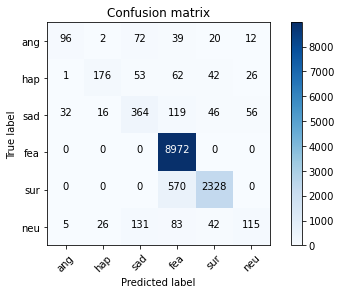

In [14]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/combined_lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)
    
with open('trained_models/combined/LR.pkl', 'wb') as f:
    pickle.dump(lr_classifier, f)

[0.00419042 0.00233716 0.009974   ... 0.         0.         0.        ]


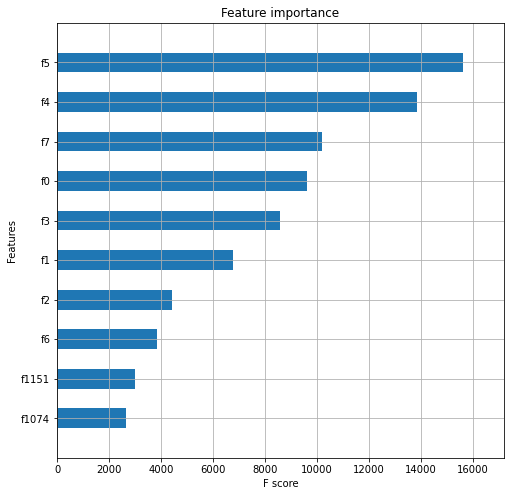

In [17]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)
contribution_scores = xgb_classifier.feature_importances_
print(contribution_scores)

Test Set Accuracy =  0.948
Test Set F-score =  0.733
Test Set Precision =  0.780
Test Set Recall =  0.701
              precision    recall  f1-score   support

         ang       0.72      0.50      0.59       241
         hap       0.77      0.63      0.69       360
         sad       0.63      0.66      0.65       633
         fea       0.99      1.00      0.99      8972
         sur       0.96      1.00      0.98      2898
         neu       0.61      0.41      0.49       402

    accuracy                           0.95     13506
   macro avg       0.78      0.70      0.73     13506
weighted avg       0.94      0.95      0.94     13506

Confusion matrix, without normalization
[[ 121   11   68   20   10   11]
 [   3  227   53   23   22   32]
 [  38   24  418   52   39   62]
 [   0    0    0 8972    0    0]
 [   0    0    0    0 2898    0]
 [   7   33  122   33   41  166]]


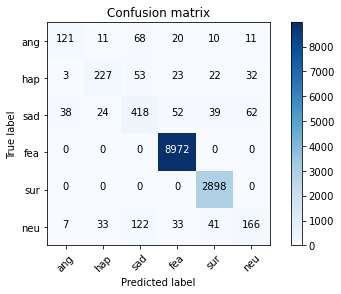

In [18]:
# Load predicted probabilities
with open('pred_probas/combined_rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('pred_probas/combined_xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/combined_svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('pred_probas/combined_mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('pred_probas/combined_mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('pred_probas/combined_lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)

with open('pred_probas/combined_lstm_classifier.pkl', 'rb') as f:
    lstm_pred_probs = pickle.load(f)

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/5.0
# Show metrics
display_results(y_test, ensemble_pred_probs)